# Experiment: the effect of proxy features on the performance of a classifier

While working on the capstone project 01 (CP01), I observed suspiciously high accuarcy and precision for both the training and test dataset. Extremely high accuarcy and precision (close to 1) could be an indication of a predictor or combination of predictor features are acting as a proxy for the target values (infant death or infant lives). There are three features in the final dataset that are only related to infants that died. These are ICD code for the cause of infant death of the infant (UC0D), cause of infant death recode (UCODR130), and manner of death. These three aforementioned features have a range of values for infants who died, but one value for all live infants. <br><br> I used a dataset that uses height and weight of an idividual to predict the gender to investigate and highlight the effect of proxy features on the apparent performance of the predictor. Additional feature was added that acts as a proxy for the target values (female or male). The additional feature has the value "Adam" for males and "Eve" for females. The performance of the classifier with the proxy features is compared to the the performance of the classifier without the proxy features. The results show, the performance of the classifier with proxy features is ~100% accuracy/precision whereas the performance of the classifier without the proxy features is ~92% accuracy/precision. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import sklearn.model_selection

Load data without additional proxy features

In [2]:
dflog_orig = pd.read_csv("data/01_heights_weights_genders.csv")
dflog_orig.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


Load data with additional feature that has a value of "Adam" if gender is male and "Eve" if gender is female

In [3]:
dflog = pd.read_csv("data/new_list")
dflog.head()

,Gender,Height,Weight,FirstPerson
0,Male,73.847017,241.893563,Adam
1,Male,68.781904,162.310473,Adam
2,Male,74.110105,212.740856,Adam
3,Male,71.730978,220.042470,Adam
4,Male,69.881796,206.349801,Adam


Plot the weight and height of both males and females to show the linear relationship between height and weight.

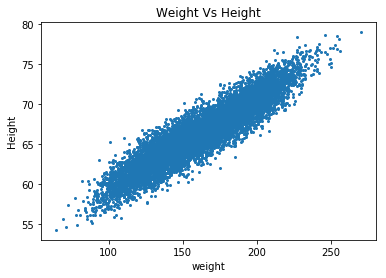

In [4]:
plt.scatter(dflog.Weight, dflog.Height,s=4);
plt.xlabel('weight')
plt.ylabel('Height')
plt.title('Weight Vs Height')

Plot height/weight of males and females using different colors.

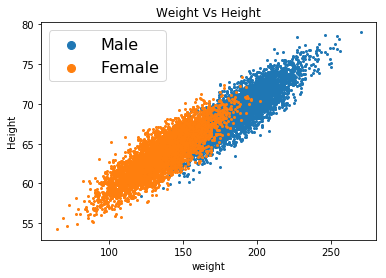

In [6]:
plt.scatter(dflog[dflog.Gender=='Male'].Weight, dflog[dflog.Gender=='Male'].Height,s=4,label='Male');
plt.scatter(dflog[dflog.Gender=='Female'].Weight, dflog[dflog.Gender=='Female'].Height,s=4,label='Female');
plt.xlabel('weight')
plt.ylabel('Height')
plt.title('Weight Vs Height')
plt.legend(fontsize=16,markerscale=4)

The added proxy feature ("FirstPerson") is categorical. Let's get the dummy variable for all the possible values ("Adam" and "Eve").

In [7]:
categ_att = ["FirstPerson"]

In [8]:
dflog = pd.get_dummies(dflog, prefix=categ_att, columns=categ_att)
dflog.head()

,Gender,Height,Weight,FirstPerson_Adam,FirstPerson_Eve
0,Male,73.847017,241.893563,1,0
1,Male,68.781904,162.310473,1,0
2,Male,74.110105,212.740856,1,0
3,Male,71.730978,220.042470,1,0
4,Male,69.881796,206.349801,1,0


Let's look at the features of the dataset with additional proxy columns.

In [9]:
list(dflog.columns)

['Gender', 'Height', 'Weight', 'FirstPerson_Adam', 'FirstPerson_Eve']

Lets look at the features of the original dataset without proxy columns

In [10]:
list(dflog_orig.columns)

['Gender', 'Height', 'Weight']

The following function takes regularization parameters, train set, test set, and nfolds and returns the best classifier. 

In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

The following function splits dataset into train and test sets and uses the function defined above (cv_optimize) to use the best estimator and returns the train/test datasets, the classifier and prints the performance of the classifier.

In [13]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

## 1. Predictor using that dataset with proxy features

Lets get the best classifier and its performance using the function defined (do_classify) above and the dataset that consists of proxy features (FirstPerson_Adam and FirstPerson_Eve).

In [14]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog, ['Weight', 'Height','FirstPerson_Adam','FirstPerson_Eve'], 'Gender','Female')

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 1}
Accuracy on training data: 1.00
Accuracy on test data:     1.00


The results show accuracy of 1.00 for both training/test datasets.

In [53]:
print("The coefficients for weight, height, FirstPerson_Adam, and FirstPerson_Eve are {:.3f}, {:.3f}, {:.3f}, and {:.3f} respectively ".format
      (clf_l.coef_[0,0], clf_l.coef_[0,1], clf_l.coef_[0,2],clf_l.coef_[0,3]))

The coefficients for weight, height, FirstPerson_Adam, and FirstPerson_Eve are -0.099, 0.241, -5.405, and 5.404 respectively 


Lets print out the size of the training/test set predictors and training/test set target features:

In [23]:
print(Xtrain_l.shape, ytrain_l.shape, Xtest_l.shape, ytest_l.shape)

(8000, 4) (8000,) (2000, 4) (2000,)


In [25]:
SS_train = Xtrain_l.shape[0] 
SS_test = Xtest_l.shape[0]
PP_train = round(np.sum(ytrain_l)/SS_train,3)
NP_train = round(np.sum(ytrain_l == 0)/SS_train,3)
PP_test = round(np.sum(ytest_l)/SS_test,3)
NP_test = round(np.sum(ytest_l == 0)/SS_test,3)

In [28]:
print("The number of records in the training data set and test data set are {} and {} respectively.".format(
    SS_train,SS_test))
print("The proportion of positive and negative labels in the training data set are {} and {} respectively.".format(
    PP_train,NP_train))
print("The proportion of positive and negative labels in the test data set are {} and {} respectively.".format(
    PP_test,NP_test))

The number of records in the training data set and test data set are 8000 and 2000 respectively.
The proportion of positive and negative labels in the training data set are 0.498 and 0.502 respectively.
The proportion of positive and negative labels in the test data set are 0.506 and 0.494 respectively.


The following extracts the confusion matrix of the test dataset to compute the various performance metrics.

In [29]:
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(ytest_l,clf_l.predict(Xtest_l))
print(cm_test)
cm_test = pd.DataFrame(cm_test)

[[ 987    0]
 [   0 1013]]


In [30]:
TN_test = cm_test[0][0];TP_test = cm_test[1][1];FP_test = cm_test[0][1]; FN_test = cm_test[1][0]

In [38]:
print("The number of true negative, true positive, false positive, and false negative in the test dataset are {}, {}, {} and {} respectively.".format(
    TN_test, TP_test, FP_test, FN_test))

The number of true negative, true positive, false positive, and false negative in the test dataset are 987, 1013, 0 and 0 respectively.


In [39]:
TPR_test = round(TP_test/(TP_test+FN_test),3) #true positive rate (Recall)

TNR_test = round(TN_test/(TN_test+FP_test),3) #true negative rate (Specifity)

PPV_test = round(TP_test/(TP_test+FP_test),3) #positive predictive value (Precision)

NPV_test = round(TN_test/(TN_test+FN_test),3) # Negative predictive value

FPR_test = round(FP_test/(FP_test+TN_test),3) # Fall out or false positive rate

FNR_test = round(FN_test/(TP_test+FN_test),3) # False negative rate

FDR_test = round(FP_test/(TP_test+FP_test),3) # False discovery rate

ACC_test = round((TP_test+TN_test)/(TP_test+FP_test+FN_test+TN_test),3) # Overall accuracy

The following extracts the confusion matrix of the training dataset to compute the various performance metrics.

In [40]:
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(ytrain_l,clf_l.predict(Xtrain_l))
print(cm_train)
cm_train = pd.DataFrame(cm_train)

[[4013    0]
 [   0 3987]]


In [41]:
TN_train = cm_train[0][0];TP_train = cm_train[1][1];FP_train = cm_train[0][1]; FN_train = cm_train[1][0]

In [42]:
print("The number of true negative, true positive, false positive, and false negative in the training dataset are {}, {}, {} and {} respectively.".format(
    TN_train, TP_train, FP_train, FN_train))

The number of true negative, true positive, false positive, and false negative in the training dataset are 4013, 3987, 0 and 0 respectively.


In [43]:
TPR_train = round(TP_train/(TP_train+FN_train),3) #true positive rate (Recall)

TNR_train = round(TN_train/(TN_train+FP_train),3) #true negative rate (Specifity)

PPV_train = round(TP_train/(TP_train+FP_train),3) #positive predictive value (Precision)

NPV_train = round(TN_train/(TN_train+FN_train),3) # Negative predictive value

FPR_train = round(FP_train/(FP_train+TN_train),3) # Fall out or false positive rate

FNR_train = round(FN_train/(TP_train+FN_train),3) # False negative rate

FDR_train = round(FP_train/(TP_train+FP_train),3) # False discovery rate

ACC_train = round((TP_train+TN_train)/(TP_train+FP_train+FN_train+TN_train),3) # Overall accuracy

#### Performance Table

In [44]:
performance_data = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train,NP_train,SS_train,ACC_train,PPV_train,TPR_train,TNR_train],
                             ['Test Set',PP_test,NP_test,SS_test,ACC_test,PPV_test,TPR_test,TNR_test]])

In [45]:
performance_table = pd.DataFrame(data=performance_data[1:,1:],
                      index=performance_data[1:,0],
                      columns=performance_data[0,1:])

In [46]:
#PP: Proportion of positive labels
#NP: Proportion of negative labels
#SS: Total number of records
#TNR: Total negative rate
performance_table

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.498,0.502,8000,1.0,1.0,1.0,1.0
Test Set,0.506,0.494,2000,1.0,1.0,1.0,1.0


## 2. Predictor using that dataset with proxy features

Lets get the best classifier and its performance using the function defined (do_classify) and the original dataset without proxy features.

In [47]:
clf_l_o, Xtrain_l_o, ytrain_l_o, Xtest_l_o, ytest_l_o  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog_orig, ['Weight', 'Height'], 'Gender','Female')

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.92
Accuracy on test data:     0.93


The results show accuracy of 0.92 and 0.93 for the training and test dataset respectively.

In [52]:
print("The coefficients for weight and height are {:.3f} and {:.3f} respectively.".format
      (clf_l_o.coef_[0,0], clf_l_o.coef_[0,1]))

The coefficients for weight and height are -0.189 and 0.458 respectively.


Lets print out the size of the training/test set predictors and training/test set target features:

In [54]:
print(Xtrain_l_o.shape, ytrain_l_o.shape, Xtest_l_o.shape, ytest_l_o.shape)

(8000, 2) (8000,) (2000, 2) (2000,)


In [56]:
SS_train_o = Xtrain_l_o.shape[0] 
SS_test_o = Xtest_l_o.shape[0]
PP_train_o = round(np.sum(ytrain_l_o)/SS_train_o,3)
NP_train_o = round(np.sum(ytrain_l_o == 0)/SS_train_o,3)
PP_test_o = round(np.sum(ytest_l_o)/SS_test_o,3)
NP_test_o = round(np.sum(ytest_l_o == 0)/SS_test_o,3)

In [58]:
print("The number of records in the training data set and test data set are {} and {} respectively.".format(
    SS_train_o,SS_test_o))
print("The proportion of positive and negative labels in the training data set are {} and {} respectively.".format(
    PP_train_o,NP_train_o))
print("The proportion of positive and negative labels in the test data set are {} and {} respectively.".format(
    PP_test_o,NP_test_o))

The number of records in the training data set and test data set are 8000 and 2000 respectively.
The proportion of positive and negative labels in the training data set are 0.499 and 0.501 respectively.
The proportion of positive and negative labels in the test data set are 0.505 and 0.494 respectively.


The following extracts the confusion matrix of the test dataset to compute the various performance metrics.

In [60]:
from sklearn.metrics import confusion_matrix
cm_test_o = confusion_matrix(ytest_l_o,clf_l_o.predict(Xtest_l_o))
print(cm_test_o)
cm_test_o = pd.DataFrame(cm_test_o)

[[931  58]
 [ 79 932]]


In [61]:
TN_test_o = cm_test_o[0][0];TP_test_o = cm_test_o[1][1];FP_test_o = cm_test_o[0][1]; FN_test_o = cm_test_o[1][0]

In [62]:
print("The number of true negative, true positive, false positive, and false negative in the test dataset are {}, {}, {} and {} respectively.".format(
    TN_test_o, TP_test_o, FP_test_o, FN_test_o))

The number of true negative, true positive, false positive, and false negative in the test dataset are 931, 932, 79 and 58 respectively.


In [72]:
TPR_test_o = round(TP_test_o/(TP_test_o+FN_test_o),3) #true positive rate (Recall)

TNR_test_o = round(TN_test_o/(TN_test_o+FP_test_o),3) #true negative rate (Specifity)

PPV_test_o = round(TP_test_o/(TP_test_o+FP_test_o),3) #positive predictive value (Precision)

NPV_test_o = round(TN_test_o/(TN_test_o+FN_test_o),3) # Negative predictive value

FPR_test_o = round(FP_test_o/(FP_test_o+TN_test_o),3) # Fall out or false positive rate

FNR_test_o = round(FN_test_o/(TP_test_o+FN_test_o),3) # False negative rate

FDR_test_o = round(FP_test_o/(TP_test_o+FP_test_o),3) # False discovery rate

ACC_test_o = round((TP_test_o+TN_test_o)/(TP_test_o+FP_test_o+FN_test_o+TN_test_o),3) # Overall accuracy

The following extracts the confusion matrix of the training dataset to compute the various performance metrics.

In [64]:
from sklearn.metrics import confusion_matrix
cm_train_o = confusion_matrix(ytrain_l_o,clf_l_o.predict(Xtrain_l_o))
print(cm_train_o)
cm_train_o = pd.DataFrame(cm_train_o)

[[3675  336]
 [ 334 3655]]


In [66]:
TN_train_o = cm_train_o[0][0];TP_train_o = cm_train_o[1][1];FP_train_o = cm_train_o[0][1]; FN_train_o = cm_train_o[1][0]

In [67]:
print("The number of true negative, true positive, false positive, and false negative in the training dataset are {}, {}, {} and {} respectively.".format(
    TN_train_o, TP_train_o, FP_train_o, FN_train_o))

The number of true negative, true positive, false positive, and false negative in the training dataset are 3675, 3655, 334 and 336 respectively.


In [70]:
TPR_train_o = round(TP_train_o/(TP_train_o+FN_train_o),3) #true positive rate (Recall)

TNR_train_o = round(TN_train_o/(TN_train_o+FP_train_o),3) #true negative rate (Specifity)

PPV_train_o = round(TP_train_o/(TP_train_o+FP_train_o),3) #positive predictive value (Precision)

NPV_train_o = round(TN_train_o/(TN_train_o+FN_train_o),3) # Negative predictive value

FPR_train_o = round(FP_train_o/(FP_train_o+TN_train_o),3) # Fall out or false positive rate

FNR_train_o = round(FN_train_o/(TP_train_o+FN_train_o),3) # False negative rate

FDR_train_o = round(FP_train_o/(TP_train_o+FP_train_o),3) # False discovery rate

ACC_train_o = round((TP_train_o+TN_train_o)/(TP_train_o+FP_train_o+FN_train_o+TN_train_o),3) # Overall accuracy

#### Performance Table

In [76]:
performance_data_o = np.array([['','PP','NP','SS','ACCURACY','PRECISION','RECALL','TNR'],
                             ['Training Set',PP_train_o,NP_train_o,SS_train_o,ACC_train_o,PPV_train_o,TPR_train_o,TNR_train_o],
                             ['Test Set',PP_test_o,NP_test_o,SS_test_o,ACC_test_o,PPV_test_o,TPR_test_o,TNR_test_o]])

In [77]:
performance_table_o = pd.DataFrame(data=performance_data_o[1:,1:],
                      index=performance_data_o[1:,0],
                      columns=performance_data_o[0,1:])

In [78]:
#PP: Proportion of positive labels
#NP: Proportion of negative labels
#SS: Total number of records
#TNR: Total negative rate
performance_table_o

,PP,NP,SS,ACCURACY,PRECISION,RECALL,TNR
Training Set,0.499,0.501,8000,0.916,0.916,0.916,0.917
Test Set,0.505,0.494,2000,0.932,0.922,0.941,0.922
